In [169]:
from tracemalloc import stop
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
sys.path.insert(1, "D:/AppProgPython/appprog/Lab4")
from df_functions import make_dataframe
from preprocess import preprocess_text

In [170]:
def visualization(epochs, train_losses, valid_losses, train_accuracy, valid_accuracy, batch_size, lr):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label=f'Training Loss (lr={lr}, batch_size={batch_size})')
    plt.plot(range(1, epochs + 1), valid_losses, label=f'Validation Loss (lr={lr}, batch_size={batch_size})')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracy, label=f'Training Accuracy (lr={lr}, batch_size={batch_size})')
    plt.plot(range(1, epochs + 1), valid_accuracy, label=f'Validation Accuracy (lr={lr}, batch_size={batch_size})')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.tight_layout()
    plt.show()

In [171]:
def change_label(data:pd.DataFrame, rate: int) -> pd.DataFrame:
    """Changes labels in the dataframe"""
    data.dropna(inplace=True)
    labels = lambda x: 1 if x == rate else 0
    data['label'] = data['Рейтинг'].apply(labels)
    return data

In [172]:
def load_data(file_path: str) -> pd.DataFrame:
    """Loads data for csv file and preprocesses texts for vectorizing"""
    data = make_dataframe(file_path)
    data = preprocess_text(data)
    return data

In [173]:
def vectorizer(df: pd.DataFrame):
    """Vectorizes dataframe"""
    cv = CountVectorizer(max_features=1000, stop_words=stopwords.words('russian'))
    sparse_matrix = cv.fit_transform(df["Текст отзыва"]).toarray()
    return sparse_matrix

In [174]:
def split_data(all_data, df:pd.DataFrame):
    """Splits data into train and test samples"""
    text = np.array(df["label"])
    x_train, x_test, y_train, y_test = train_test_split(all_data, text)
    return x_train, x_test, y_train, y_test


In [175]:
df = load_data('D:/AppProgPython/appprog/csv/final.csv')


In [176]:
changed = change_label(df, 5)
vec = vectorizer(changed)
df.to_csv("D:/AppProgPython/appprog/csv/prepro.csv")
df.dropna(inplace =True)
df

,Абсолютный путь,Рейтинг,Текст отзыва,Количество слов,label
0,D:\AppProgPython\appprog\dataset\4\0000.txt,4,01 ноябрь решать пополнять свой счет банкомат ...,163,0
1,D:\AppProgPython\appprog\dataset\4\0001.txt,4,здраствовать 26.05 2023 заказывать дебетовый к...,179,0
2,D:\AppProgPython\appprog\dataset\4\0002.txt,4,добрый знак являться дружелюбный тон специалис...,130,0
3,D:\AppProgPython\appprog\dataset\4\0003.txt,4,выходить работа приходиться оформлять карта ал...,274,0
4,D:\AppProgPython\appprog\dataset\4\0004.txt,4,10 сентябрь приложение альфа банка совершать п...,199,0
...,...,...,...,...,...
995,D:\AppProgPython\appprog\dataset\5\0495.txt,5,30 сентябрь решать становиться клиент альфа-ба...,74,1
996,D:\AppProgPython\appprog\dataset\5\0496.txt,5,1 октябрь обращаться контактный центр альфа ба...,69,1
997,D:\AppProgPython\appprog\dataset\5\0497.txt,5,добрый день пользователь дебетовый карта альфа...,228,1
998,D:\AppProgPython\appprog\dataset\5\0498.txt,5,добрый день приходить уведомление мобильный пр...,194,1


In [196]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(1000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
x_train, x_tmp, y_train, y_tmp = split_data(vec, changed)
x_test, x_valid, y_test, y_valid = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42)

In [197]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
x_valid = Variable(torch.from_numpy(x_valid)).float()
y_valid = Variable(torch.from_numpy(y_valid)).long()

In [198]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

In [199]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = 50
loss_values = []
models = []

Learning rate: 0.0001
Batch size: 32
Epoch 1/50, Training Loss: 0.6945, Training Accuracy: 0.5040, Validation Loss: 0.6864, Validation Accuracy: 0.5280
Epoch 2/50, Training Loss: 0.6888, Training Accuracy: 0.5040, Validation Loss: 0.6825, Validation Accuracy: 0.5280
Epoch 3/50, Training Loss: 0.6831, Training Accuracy: 0.5040, Validation Loss: 0.6794, Validation Accuracy: 0.5280
Epoch 4/50, Training Loss: 0.6775, Training Accuracy: 0.5040, Validation Loss: 0.6739, Validation Accuracy: 0.5280
Epoch 5/50, Training Loss: 0.6717, Training Accuracy: 0.5040, Validation Loss: 0.6681, Validation Accuracy: 0.5280
Epoch 6/50, Training Loss: 0.6623, Training Accuracy: 0.5147, Validation Loss: 0.6613, Validation Accuracy: 0.5600
Epoch 7/50, Training Loss: 0.6514, Training Accuracy: 0.6027, Validation Loss: 0.6521, Validation Accuracy: 0.6400
Epoch 8/50, Training Loss: 0.6375, Training Accuracy: 0.6827, Validation Loss: 0.6405, Validation Accuracy: 0.6960
Epoch 9/50, Training Loss: 0.6213, Training

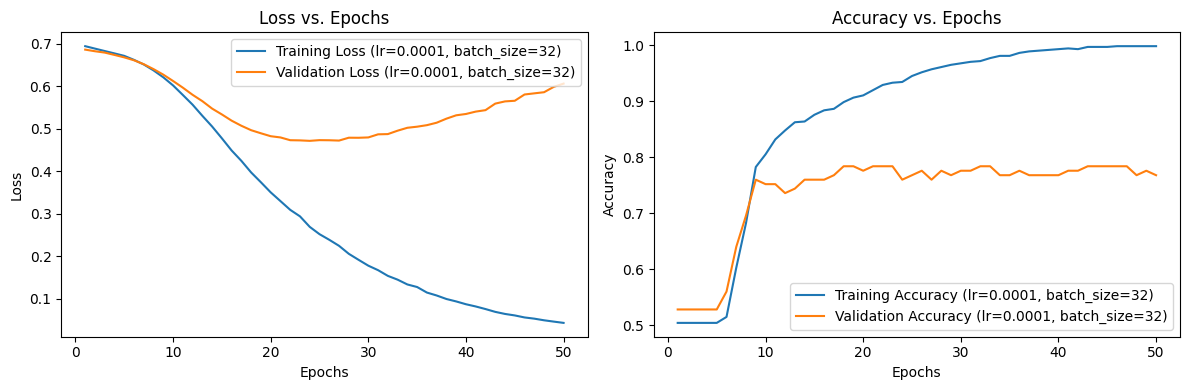

Learning rate: 0.0001
Batch size: 64
Epoch 1/50, Training Loss: 0.0424, Training Accuracy: 0.9987, Validation Loss: 0.6127, Validation Accuracy: 0.7680
Epoch 2/50, Training Loss: 0.0386, Training Accuracy: 0.9987, Validation Loss: 0.6247, Validation Accuracy: 0.7680
Epoch 3/50, Training Loss: 0.0358, Training Accuracy: 0.9987, Validation Loss: 0.6306, Validation Accuracy: 0.7680
Epoch 4/50, Training Loss: 0.0334, Training Accuracy: 0.9987, Validation Loss: 0.6355, Validation Accuracy: 0.7680
Epoch 5/50, Training Loss: 0.0312, Training Accuracy: 0.9987, Validation Loss: 0.6473, Validation Accuracy: 0.7680
Epoch 6/50, Training Loss: 0.0291, Training Accuracy: 0.9987, Validation Loss: 0.6569, Validation Accuracy: 0.7680
Epoch 7/50, Training Loss: 0.0272, Training Accuracy: 1.0000, Validation Loss: 0.6627, Validation Accuracy: 0.7680
Epoch 8/50, Training Loss: 0.0253, Training Accuracy: 1.0000, Validation Loss: 0.6722, Validation Accuracy: 0.7680
Epoch 9/50, Training Loss: 0.0238, Training

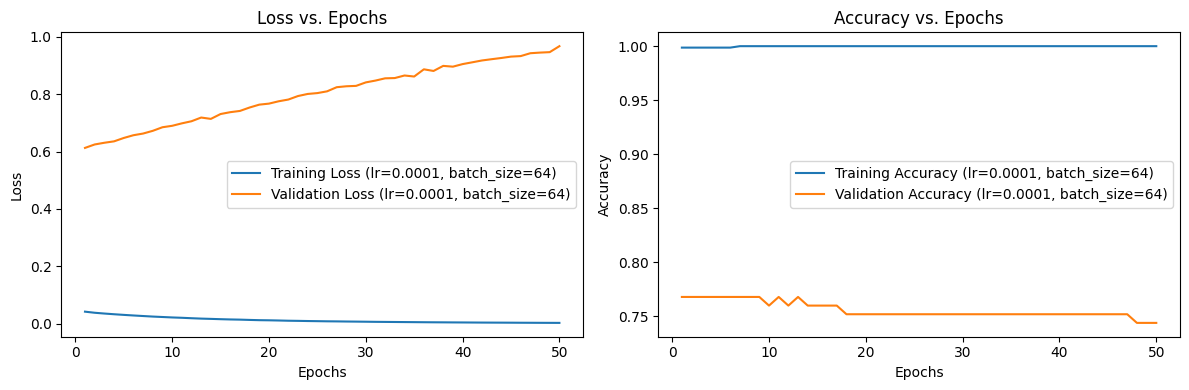

Learning rate: 0.0001
Batch size: 128
Epoch 1/50, Training Loss: 0.0032, Training Accuracy: 1.0000, Validation Loss: 0.9698, Validation Accuracy: 0.7440
Epoch 2/50, Training Loss: 0.0030, Training Accuracy: 1.0000, Validation Loss: 0.9799, Validation Accuracy: 0.7440
Epoch 3/50, Training Loss: 0.0028, Training Accuracy: 1.0000, Validation Loss: 0.9906, Validation Accuracy: 0.7440
Epoch 4/50, Training Loss: 0.0026, Training Accuracy: 1.0000, Validation Loss: 1.0010, Validation Accuracy: 0.7440
Epoch 5/50, Training Loss: 0.0024, Training Accuracy: 1.0000, Validation Loss: 1.0108, Validation Accuracy: 0.7440
Epoch 6/50, Training Loss: 0.0023, Training Accuracy: 1.0000, Validation Loss: 1.0213, Validation Accuracy: 0.7440
Epoch 7/50, Training Loss: 0.0021, Training Accuracy: 1.0000, Validation Loss: 1.0316, Validation Accuracy: 0.7440
Epoch 8/50, Training Loss: 0.0020, Training Accuracy: 1.0000, Validation Loss: 1.0410, Validation Accuracy: 0.7440
Epoch 9/50, Training Loss: 0.0019, Trainin

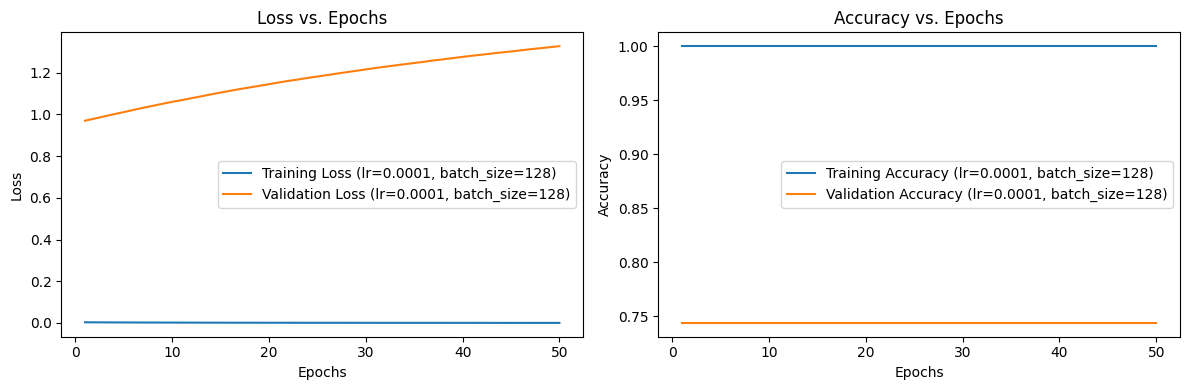

Learning rate: 0.001
Batch size: 32
Epoch 1/50, Training Loss: 0.0006, Training Accuracy: 1.0000, Validation Loss: 1.6805, Validation Accuracy: 0.7360
Epoch 2/50, Training Loss: 0.0003, Training Accuracy: 1.0000, Validation Loss: 1.7452, Validation Accuracy: 0.7280
Epoch 3/50, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Loss: 1.8497, Validation Accuracy: 0.7360
Epoch 4/50, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Loss: 1.8490, Validation Accuracy: 0.7280
Epoch 5/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 1.8832, Validation Accuracy: 0.7280
Epoch 6/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 1.9428, Validation Accuracy: 0.7280
Epoch 7/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 1.9369, Validation Accuracy: 0.7280
Epoch 8/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 1.9845, Validation Accuracy: 0.7280
Epoch 9/50, Training Loss: 0.0000, Training 

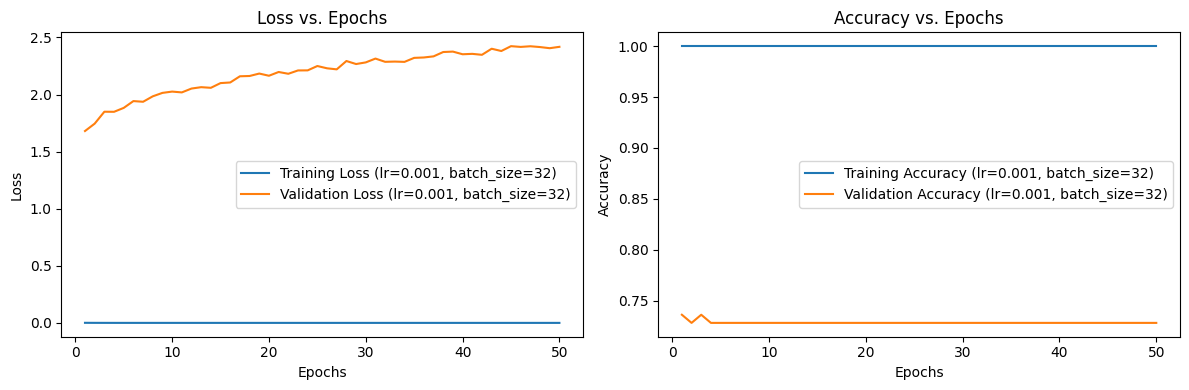

Learning rate: 0.001
Batch size: 64
Epoch 1/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 2.6350, Validation Accuracy: 0.7200
Epoch 2/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 2.8912, Validation Accuracy: 0.7280
Epoch 3/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.0035, Validation Accuracy: 0.7280
Epoch 4/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.0884, Validation Accuracy: 0.7200
Epoch 5/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.1350, Validation Accuracy: 0.7280
Epoch 6/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.1636, Validation Accuracy: 0.7280
Epoch 7/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.1760, Validation Accuracy: 0.7280
Epoch 8/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.1839, Validation Accuracy: 0.7280
Epoch 9/50, Training Loss: 0.0000, Training 

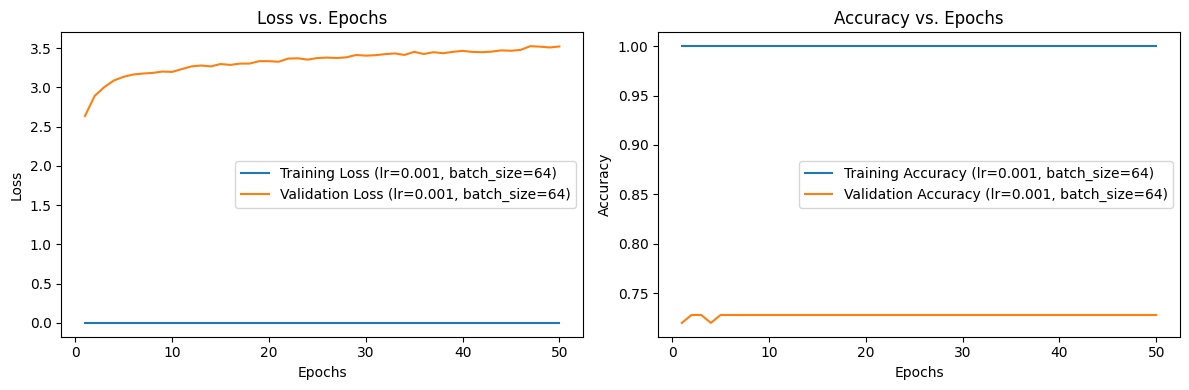

Learning rate: 0.001
Batch size: 128
Epoch 1/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.5248, Validation Accuracy: 0.7280
Epoch 2/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.5458, Validation Accuracy: 0.7280
Epoch 3/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.5653, Validation Accuracy: 0.7280
Epoch 4/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.5829, Validation Accuracy: 0.7280
Epoch 5/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.5998, Validation Accuracy: 0.7280
Epoch 6/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.6161, Validation Accuracy: 0.7280
Epoch 7/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.6307, Validation Accuracy: 0.7280
Epoch 8/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 3.6447, Validation Accuracy: 0.7280
Epoch 9/50, Training Loss: 0.0000, Training

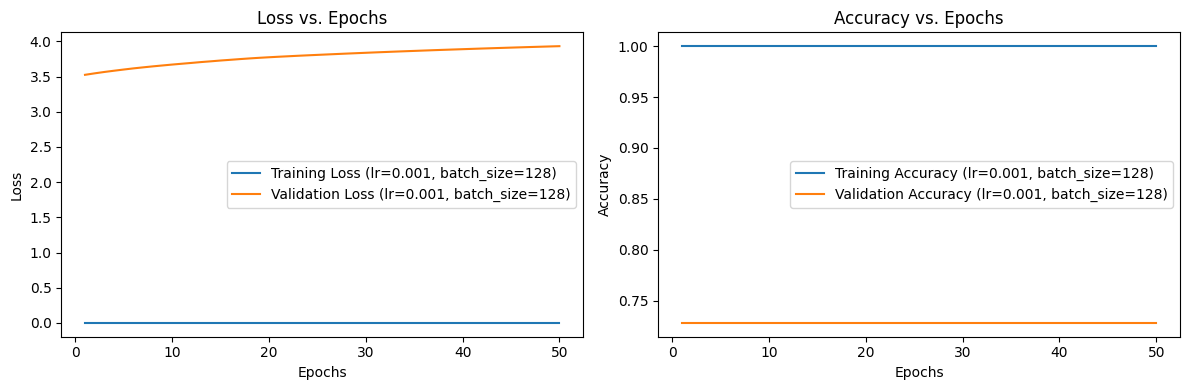

Learning rate: 0.01
Batch size: 32
Epoch 1/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1155, Validation Accuracy: 0.7280
Epoch 2/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.1985, Validation Accuracy: 0.7280
Epoch 3/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.2920, Validation Accuracy: 0.7280
Epoch 4/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.3160, Validation Accuracy: 0.7280
Epoch 5/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.3741, Validation Accuracy: 0.7280
Epoch 6/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.3556, Validation Accuracy: 0.7280
Epoch 7/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.4406, Validation Accuracy: 0.7280
Epoch 8/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.4401, Validation Accuracy: 0.7280
Epoch 9/50, Training Loss: 0.0000, Training A

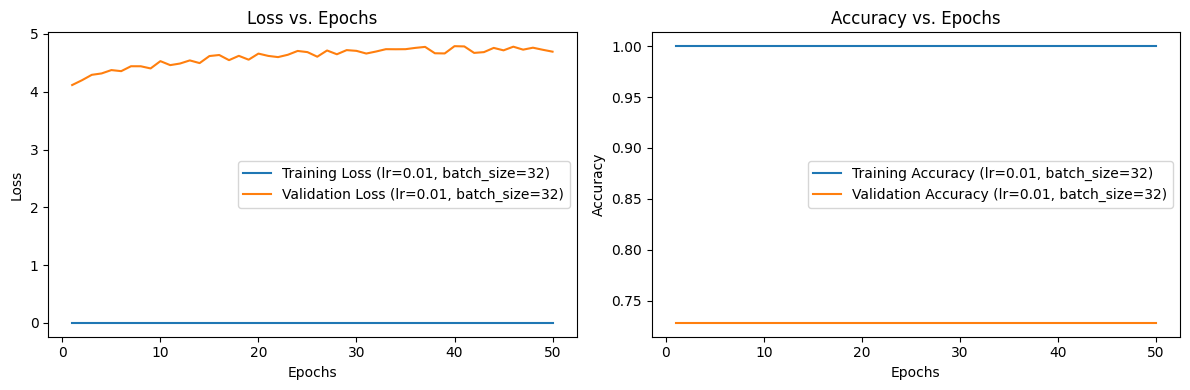

Learning rate: 0.01
Batch size: 64
Epoch 1/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.7720, Validation Accuracy: 0.7280
Epoch 2/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8206, Validation Accuracy: 0.7280
Epoch 3/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8086, Validation Accuracy: 0.7280
Epoch 4/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.7708, Validation Accuracy: 0.7280
Epoch 5/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.7842, Validation Accuracy: 0.7280
Epoch 6/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8046, Validation Accuracy: 0.7280
Epoch 7/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8059, Validation Accuracy: 0.7280
Epoch 8/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.7619, Validation Accuracy: 0.7280
Epoch 9/50, Training Loss: 0.0000, Training A

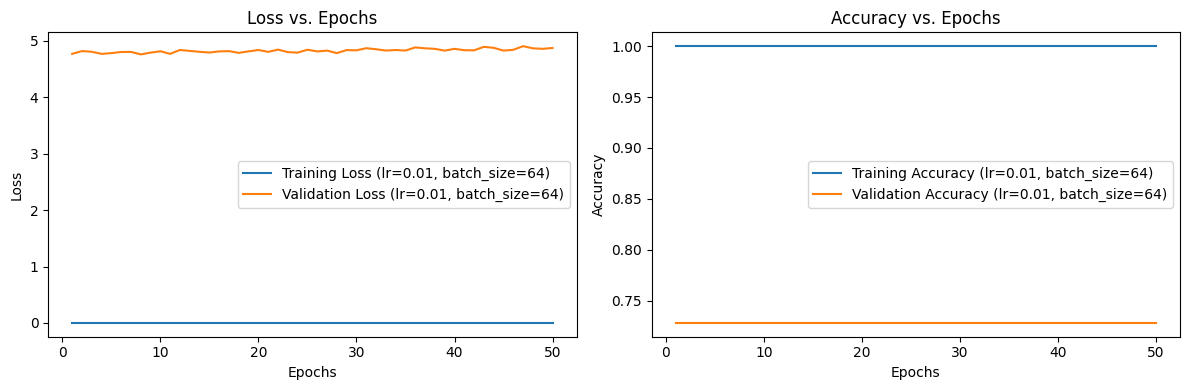

Learning rate: 0.01
Batch size: 128
Epoch 1/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8669, Validation Accuracy: 0.7280
Epoch 2/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8676, Validation Accuracy: 0.7280
Epoch 3/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8683, Validation Accuracy: 0.7280
Epoch 4/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8689, Validation Accuracy: 0.7280
Epoch 5/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8696, Validation Accuracy: 0.7280
Epoch 6/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8703, Validation Accuracy: 0.7280
Epoch 7/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8710, Validation Accuracy: 0.7280
Epoch 8/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 4.8717, Validation Accuracy: 0.7280
Epoch 9/50, Training Loss: 0.0000, Training 

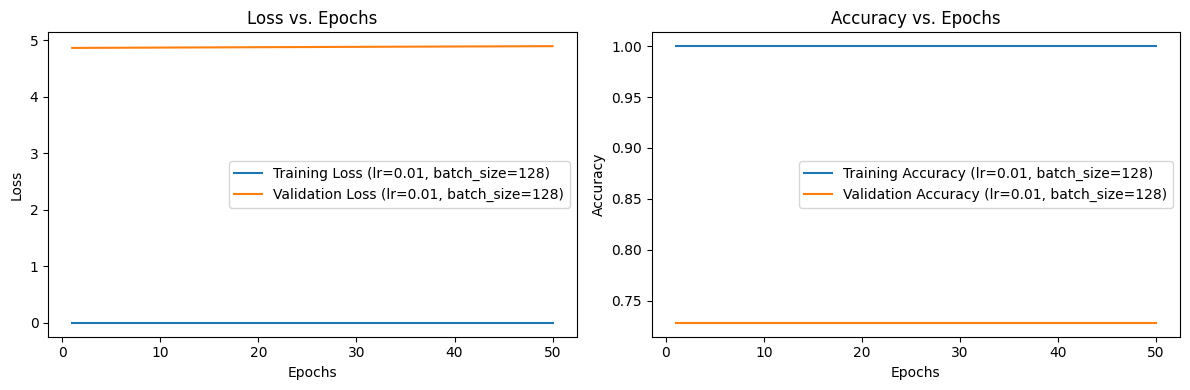

Test Accuracy: 0.7040


In [200]:
for lr in learning_rates:
    for bs in batch_sizes:
        print(f'Learning rate: {lr}')
        print(f'Batch size: {bs}')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

        # Training loop
        train_losses = []
        valid_losses = []
        train_accuracy = []
        valid_accuracy = []

        for epoch in range(epochs):
            model.train()

            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_losses.append(running_loss / len(train_loader))
            train_accuracy.append(correct_train / total_train)

            # Validation
            model.eval()

            running_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels).sum().item()

                valid_losses.append(running_loss / len(valid_loader))
                valid_accuracy.append(correct_valid / total_valid)
                print(f'Epoch {epoch + 1}/{epochs}, '
                      f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
                      f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')
                models.append(model)

        visualization(epochs, train_losses, valid_losses, train_accuracy, valid_accuracy, bs, lr)

# Evaluate model on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')


In [210]:
batch_size = 32
lr = 0.0001
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Training loop
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

epochs = 10

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

            # Validation
    model.eval()

    running_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
        valid_losses.append(running_loss / len(valid_loader))
        valid_accuracy.append(correct_valid / total_valid)
        print(f'Epoch {epoch + 1}/{epochs}, '
            f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
            f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')

Epoch 1/10, Training Loss: 0.6936, Training Accuracy: 0.5013, Validation Loss: 0.6905, Validation Accuracy: 0.5040
Epoch 2/10, Training Loss: 0.6876, Training Accuracy: 0.5453, Validation Loss: 0.6847, Validation Accuracy: 0.5440
Epoch 3/10, Training Loss: 0.6811, Training Accuracy: 0.6253, Validation Loss: 0.6776, Validation Accuracy: 0.6160
Epoch 4/10, Training Loss: 0.6732, Training Accuracy: 0.7080, Validation Loss: 0.6696, Validation Accuracy: 0.7440
Epoch 5/10, Training Loss: 0.6649, Training Accuracy: 0.7680, Validation Loss: 0.6606, Validation Accuracy: 0.7760
Epoch 6/10, Training Loss: 0.6547, Training Accuracy: 0.7827, Validation Loss: 0.6505, Validation Accuracy: 0.7680
Epoch 7/10, Training Loss: 0.6428, Training Accuracy: 0.7707, Validation Loss: 0.6391, Validation Accuracy: 0.7520
Epoch 8/10, Training Loss: 0.6288, Training Accuracy: 0.7880, Validation Loss: 0.6267, Validation Accuracy: 0.7440
Epoch 9/10, Training Loss: 0.6113, Training Accuracy: 0.7827, Validation Loss: 0

In [211]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model.pth')

In [212]:
sample = "единственный банк который показывать мобильный приложение сумма дата платеж \
    сохранение беспроцентный период отражаться платеж "" -  лишь минимальный платеж \
    который обеспечивать сохранение беспроцентный период необходимо очень тщательно \
    отслеживать платеж самостоятельно опираться собственный расчет банк предупреждать \
    подсказывать обязательно радость начислять штрафной процент вылет грейс \
    поддержка также нелегко получать необходимый информация прямой вопрос \
    отвечать пространный следовать рекомендация штрафной процент вылет грейс обеспечивать"
max_words = 1000
cv = CountVectorizer(max_features=max_words, stop_words=stopwords.words('russian'))
sparse_matrix = cv.fit_transform(np.array([sample])).toarray()
if sparse_matrix.shape[1] < 1000:
    sparse_matrix = np.pad(sparse_matrix, ((0, 0), (0, 1000 - sparse_matrix.shape[1])))
sparse_matrix.shape

(1, 1000)

In [213]:
review = Variable(torch.from_numpy(sparse_matrix)).float()
model = LogisticRegression()
load_checkpoint = torch.load('model.pth')
model.load_state_dict(load_checkpoint['model_state_dict'])
optimizer.load_state_dict(load_checkpoint['optimizer_state_dict'])
epoch = load_checkpoint['epoch']

model.eval()

LogisticRegression(
  (linear1): Linear(in_features=1000, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=2, bias=True)
)

In [214]:
with torch.no_grad():
    output = model(review)
    print('output: ', output)


predict = torch.argmax(output).item()

print(f"Предсказанный класс: {predict}")

output:  tensor([[0.1007, 0.1101]])
Предсказанный класс: 1
